# Урок 8. Синтез изображений

## Задание.
Реализовать синтезирование лиц из LFW с помощью DCGAN
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt

import tensorflow as tf

2021-10-14 13:53:01.123468: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Загрузка и подготовка датасета

In [2]:
# Можно еще вот так распаковать архив.
if 1:
    dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='lfw', untar=True )
    data_dir = pathlib.Path(data_dir)
else: 
    data_dir = pathlib.Path('lfw')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13233


In [20]:
img_height = 64
img_width = 64

HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=HALF_BATCH_SIZE,
  color_mode='grayscale'
)
train_ds = train_ds.shuffle(buffer_size=image_count)


Found 13233 files belonging to 5749 classes.
Using 10587 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  # batch_size=batch_size И тогда разделять ниего не нужно будет.
  )

Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


## Визуализация датасета

In [23]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    num = images.shape[0]
    for i in range(num):
       ax = plt.subplot(8, 8, i + 1)
       ax.imshow(images[i], cmap='gray')
       plt.xticks([]), plt.yticks([])
       plt.axis("off")
    plt.show()

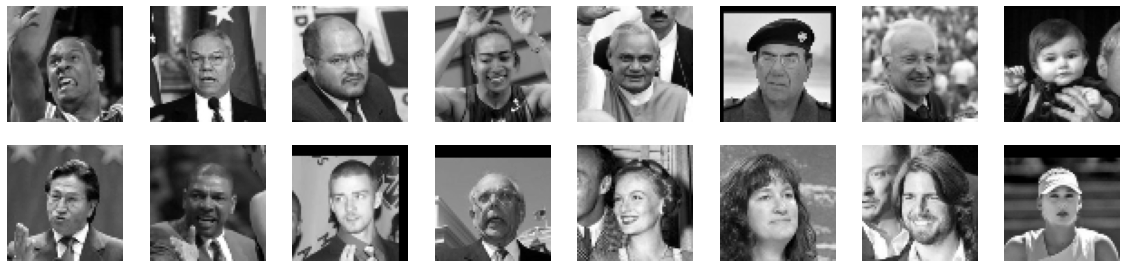

In [33]:
for images, _ in val_ds.take(1):
    plot_images(images[:16])

## Создание Генератора и Дискриминатора

In [27]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*8*8, activation='relu'),
    tf.keras.layers.Reshape((8, 8, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),   
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])
#4096
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

## Подготовка пайплайна данных и оптимизатора

In [28]:
NUM_EPOCHS = 50
INPUT_DIM = 100
LEARNING_RATE = 0.0002

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
print(noise.shape)
print(syntetic_images.shape)

(16, 100)
(16, 64, 64, 1)


In [30]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 32, 32, 128)      

## Обучение GAN

EPOCH:1
[Step  0] D Loss: 0.1084; G Loss: 10.8027
[Step 500] D Loss: 0.2511; G Loss: 0.1885


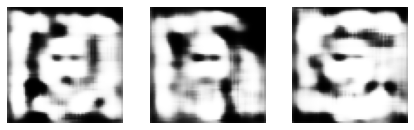

EPOCH:2
[Step  0] D Loss: 0.8270; G Loss: 0.5216
[Step 500] D Loss: 0.6867; G Loss: 4.7269


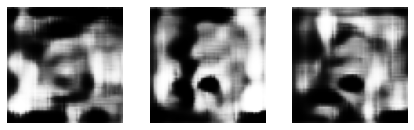

EPOCH:3
[Step  0] D Loss: 0.3286; G Loss: 4.9121
[Step 500] D Loss: 0.0057; G Loss: 11.7185


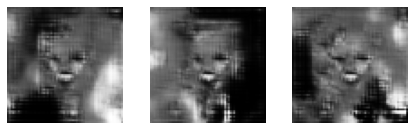

EPOCH:4
[Step  0] D Loss: 0.8307; G Loss: 4.7900
[Step 500] D Loss: 0.3219; G Loss: 2.3152


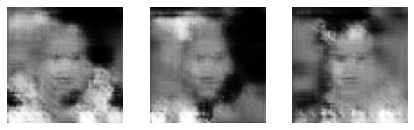

EPOCH:5
[Step  0] D Loss: 0.2836; G Loss: 3.9667
[Step 500] D Loss: 0.2215; G Loss: 2.9748


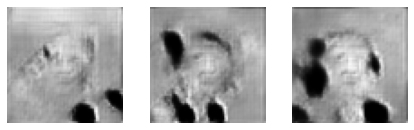

EPOCH:6
[Step  0] D Loss: 0.1005; G Loss: 6.3057
[Step 500] D Loss: 0.1651; G Loss: 10.3204


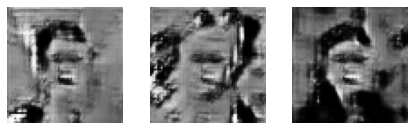

EPOCH:7
[Step  0] D Loss: 0.0470; G Loss: 7.2371
[Step 500] D Loss: 0.4849; G Loss: 6.6602


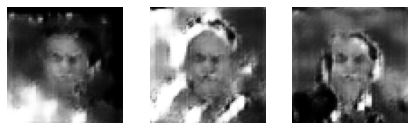

EPOCH:8
[Step  0] D Loss: 0.1568; G Loss: 3.8397
[Step 500] D Loss: 0.7727; G Loss: 6.2519


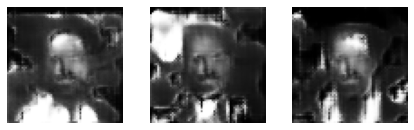

EPOCH:9
[Step  0] D Loss: 0.4509; G Loss: 4.9044
[Step 500] D Loss: 0.2969; G Loss: 4.0034


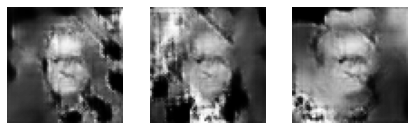

EPOCH:10
[Step  0] D Loss: 0.2288; G Loss: 6.9095
[Step 500] D Loss: 0.4051; G Loss: 5.0464


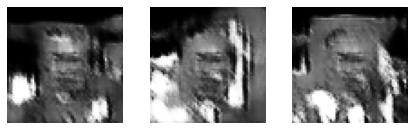

In [32]:
for epoch in range(NUM_EPOCHS):
    print(f'EPOCH:{epoch+1}')
    for step, (true_images,_) in enumerate(train_ds):
        try:
            # Train Discriminator
            true_images=(true_images-127.5)/127.5
            # if(images)
            # true_images = (tf.reshape(true_images, [-1, img_height*img_width]) - 127.5) / 127.5
            noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
            syntetic_images = generator.predict(noise)
            x_combined = np.concatenate((
                true_images, 
                syntetic_images))
            y_combined = np.concatenate((
                np.ones((HALF_BATCH_SIZE, 1), np.float32), 
                np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
            
            with tf.GradientTape() as tape:
                logits = discriminator(x_combined, training=True)
                d_loss_value = sigmoid_cross_entropy(y_combined, logits)
            grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
            optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
            
            # Train Generator
            
            noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
            y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
            
            with tf.GradientTape() as tape:
                syntetic = generator(noise, training=True)
                logits = discriminator(syntetic, training=False)
                g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
            grads = tape.gradient(g_loss_value, generator.trainable_variables)
            optimizer.apply_gradients(zip(grads, generator.trainable_variables))
            
            # Check intermediate results
            
            if step % 500 == 0:
                print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
                    step, d_loss_value.numpy(), g_loss_value.numpy()))
        except Exception as ex:
            # print(ex)
            pass

    if epoch % 2==0:
        noise = np.random.normal(0, 1, (3, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

## Тестирование свёрточного генератора

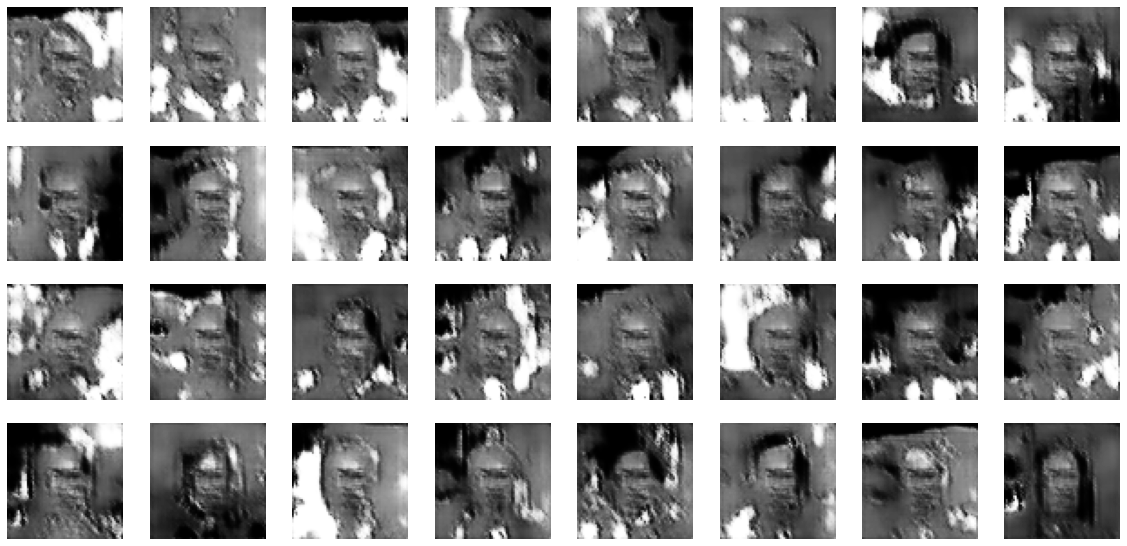

In [34]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)